In [3]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from sklearn.model_selection import train_test_split
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, StandardScaler, Normalizer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.types import StructType, StructField, DoubleType
df = pd.read_csv('../data/zomato.csv')
df.head(1)
df.isnull().sum()


url                                0
address                            0
name                               0
online_order                       0
book_table                         0
rate                            7775
votes                              0
phone                           1208
location                          21
rest_type                        227
dish_liked                     28078
cuisines                          45
approx_cost(for two people)      346
reviews_list                       0
menu_item                          0
listed_in(type)                    0
listed_in(city)                    0
dtype: int64

In [4]:
spark = SparkSession.builder \
    .appName("NBC") \
    .config("spark.driver.memory", "50g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()
sc=spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/10 22:55:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/05/10 22:55:54 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


23/05/11 06:31:59 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 921344 ms exceeds timeout 120000 ms
23/05/11 06:31:59 WARN SparkContext: Killing executors is not supported by current scheduler.
23/05/11 06:47:53 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.B

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   url                          51717 non-null  object
 1   address                      51717 non-null  object
 2   name                         51717 non-null  object
 3   online_order                 51717 non-null  object
 4   book_table                   51717 non-null  object
 5   rate                         43942 non-null  object
 6   votes                        51717 non-null  int64 
 7   phone                        50509 non-null  object
 8   location                     51696 non-null  object
 9   rest_type                    51490 non-null  object
 10  dish_liked                   23639 non-null  object
 11  cuisines                     51672 non-null  object
 12  approx_cost(for two people)  51371 non-null  object
 13  reviews_list                 51

In [ ]:

# Drop rows with missing values
df.dropna(inplace=True)


df.head(1)
df.rename({'approx_cost(for two people)': 'approx_cost_2_people',
           'listed_in(type)':'listed_in_type',
           'listed_in(city)':'listed_in_city'
          }, axis=1, inplace=True)

replace_coma = lambda x: int(x.replace(',', '')) if type(x) == np.str and x != np.nan else x 
df.votes = df.votes.astype('int')
df['approx_cost_2_people'] = df['approx_cost_2_people'].apply(replace_coma)

df = df.loc[df.rate !='NEW']
df = df.loc[df.rate !='-'].reset_index(drop=True)
new_format = lambda x: x.replace('/5', '') if type(x) == np.str else x
df.rate = df.rate.apply(new_format).str.strip().astype('float')
df.rate.head()
df.isnull().sum()
df.head(5)

df_encoded_out = df.copy()

df_encoded_out = df_encoded_out.drop(['rest_type', 'location','dish_liked' , 'cuisines' , 'reviews_list' , 'menu_item' , 'listed_in_type' , 'listed_in_city', 'address' , 'name','url', 'phone','online_order' , 'book_table'], axis=1)
df_encoded_out.head(1)


/var/folders/pj/07vjcqy93799gqmlt4jw5h3r0000gn/T/ipykernel_34095/3114635664.py:11: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  replace_coma = lambda x: int(x.replace(',', '')) if type(x) == np.str and x != np.nan else x
/var/folders/pj/07vjcqy93799gqmlt4jw5h3r0000gn/T/ipykernel_34095/3114635664.py:17: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  new_for

,rate,votes,approx_cost_2_people
0,4.1,775,800


In [28]:
def set_rating_flag(row):
    if row['rate'] > 3.7:
        return 1
    else:
        return 0

# Add a new column based on the function
df_encoded_out['output'] = df.apply(lambda row: set_rating_flag(row), axis=1)

<AxesSubplot:>

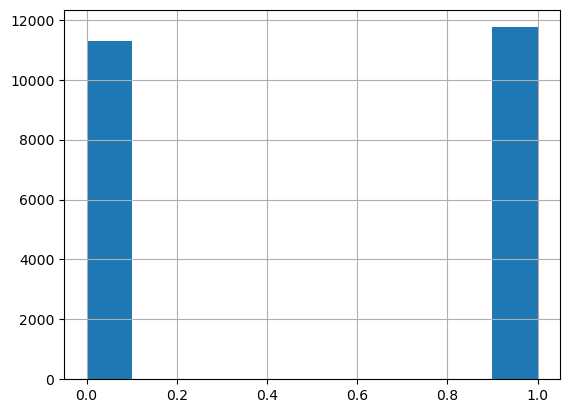

In [29]:
df_encoded_out['output'].hist()

In [30]:
df_encoded_out = df_encoded_out.drop(['rate'], axis=1)


In [31]:
df_encoded_out = df_encoded_out[df_encoded_out.apply(lambda x: pd.to_numeric(x, errors='coerce').notnull().all(), axis=1)]


In [32]:
df_encoded_out.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23046 entries, 0 to 23045
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   votes                 23046 non-null  int64
 1   approx_cost_2_people  23046 non-null  int64
 2   output                23046 non-null  int64
dtypes: int64(3)
memory usage: 720.2 KB


In [33]:
# map function to convert the data into tuples
def mapFunction(row):

    # Extract the features and target from the row 
    features = row[:-1]
    target = row[-1]

    # Create a list of tuples to save the feature index, value, target, and add 1 to each value to use  it in reduce step
    tuples = []
    print (features , target , "\n")

    # Loop through each feature index and value
    for i, x in enumerate(features):
        # Append a tuple of feature index, value, target, and count to the list
        tuples.append(((i, x, target), 1))

    # Return the list of tuples
    return tuples





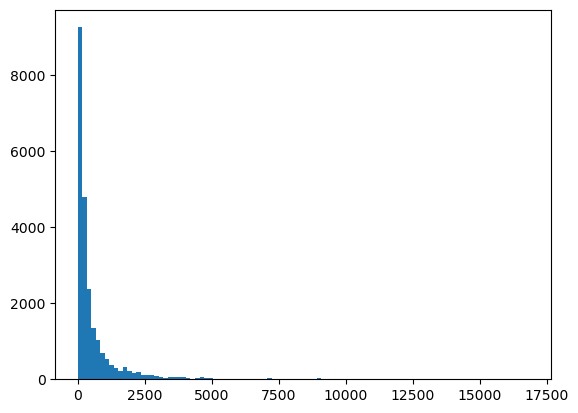

In [34]:
# plot the votes values to see the distribution
import matplotlib.pyplot as plt
plt.hist(df_encoded_out['votes'], bins=100)
plt.show()


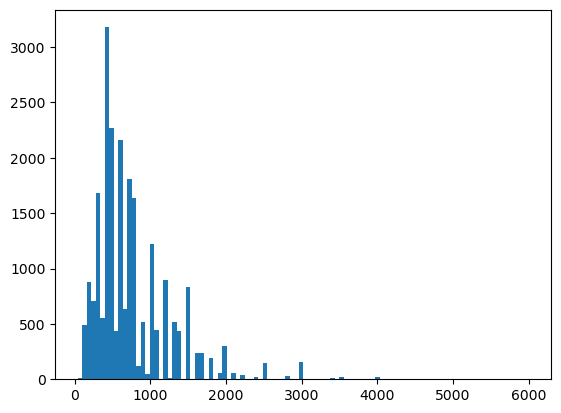

In [35]:
import matplotlib.pyplot as plt
plt.hist(df_encoded_out['approx_cost_2_people'], bins=100)
plt.show()

#### Non of the variable follow gausian distribution so we can not use meas and stander deviation to represent this distribution and use it in naive bayes classifier

#### so i will use Multinomial Naive Bayes  

In [36]:
spark_df = spark.createDataFrame(df_encoded_out)


In [37]:
train, test = spark_df.randomSplit([0.7, 0.3], seed=12345)
train = train.rdd
test = test.rdd

In [38]:
# Apply the map function to the data RDD
mappedRdd = train.flatMap(mapFunction)

In [39]:
# Sum the counts for each tuple
reducedRdd = mappedRdd.reduceByKey(lambda a, b: a + b) 



In [40]:
# Collect the frequency table as a dictionary
freqTable = reducedRdd.collectAsMap()

(9, 800) 0 

(9, 800) 0 

(10, 350) 0 

(10, 350) 0 

(27, 300) 0 

(27, 300) 0 

(28, 200) 0 

(28, 200) 0 

(29, 500) 1 

(31, 400) 0 

(31, 400) 0 

(31, 1100) 1 

(31, 1100) 1 

(32, 800) 0 

(32, 1000) 0 

(32, 1000) 0 

(34, 200) 0 

(34, 250) 0 

(34, 250) 0 

(34, 250) 0 

(34, 250) 0 

(34, 300) 0 

(34, 300) 0 

(34, 300) 1 

(34, 300) 1 

(34, 350) 0 

(34, 400) 0 

(34, 650) 0 

(34, 650) 0 

(34, 650) 0 

(34, 650) 0 

(34, 650) 0 

(34, 650) 0 

(35, 200) 0 

(35, 200) 0 

(35, 200) 0 

(37, 400) 0 

(37, 500) 1 

(37, 500) 1 

(37, 500) 1 

(37, 500) 1 

(38, 400) 0 

(38, 400) 0 

(38, 400) 0 

(38, 400) 0 

(38, 400) 0 

(38, 500) 0 

(38, 500) 0 

(38, 900) 0 

(38, 2000) 1 

(39, 300) 1 

(39, 300) 1 

(40, 200) 0 

(40, 250) 0 

(40, 250) 0 

(40, 250) 0 

(40, 300) 1 

(40, 300) 1 

(40, 300) 1 

(40, 400) 1 

(40, 500) 0 

(40, 500) 0 

(40, 600) 0 

(8, 450)(41, 100) 0 

(41, 200) 0 

 (41, 200) 0 

(8, 450) 0 

(10, 350) 0 

(27, 300) 0 

(29, 500) 1 

(30, 400)

In [41]:
freqTable

{(1, 400, 0): 1109,
 (0, 35, 0): 19,
 (1, 200, 0): 380,
 (1, 600, 0): 928,
 (0, 43, 0): 34,
 (1, 800, 0): 495,
 (1, 2000, 0): 49,
 (0, 48, 1): 16,
 (0, 51, 0): 42,
 (0, 59, 0): 65,
 (0, 64, 1): 13,
 (1, 2200, 0): 15,
 (1, 1200, 0): 141,
 (1, 1000, 0): 282,
 (0, 75, 0): 71,
 (0, 88, 1): 8,
 (0, 91, 0): 40,
 (0, 99, 0): 27,
 (0, 104, 1): 18,
 (0, 107, 0): 28,
 (0, 115, 0): 33,
 (0, 128, 1): 17,
 (0, 131, 0): 19,
 (0, 136, 1): 11,
 (0, 139, 0): 20,
 (0, 152, 1): 31,
 (0, 155, 0): 33,
 (0, 163, 0): 19,
 (0, 171, 0): 19,
 (0, 176, 1): 18,
 (0, 179, 0): 21,
 (0, 192, 1): 13,
 (0, 195, 0): 16,
 (1, 1600, 0): 19,
 (0, 200, 1): 13,
 (0, 203, 0): 23,
 (0, 211, 0): 13,
 (0, 216, 1): 13,
 (0, 232, 1): 20,
 (0, 235, 0): 16,
 (0, 243, 0): 12,
 (0, 248, 1): 4,
 (0, 256, 1): 7,
 (0, 280, 1): 10,
 (0, 283, 0): 18,
 (0, 288, 1): 9,
 (0, 291, 0): 22,
 (0, 299, 0): 4,
 (0, 307, 0): 6,
 (0, 323, 0): 17,
 (0, 336, 1): 6,
 (0, 339, 0): 4,
 (0, 347, 0): 5,
 (0, 384, 1): 8,
 (0, 395, 0): 11,
 (0, 419, 0): 6,
 

# Naive Bayes with laplace smothing
<img src="https://qph.cf2.quoracdn.net/main-qimg-b6736b7224ff76ac834205c019c96e6b" width="50%" height="30%">

In [42]:

def predict(row, frequencyTable, test=False):
    frequencyTable = frequencyTable.value
    # Extract the features and target from the line
    features = row[:-1]
    if test:
        target = int(row[-1])

    # Posterior probabilities for the target classes
    posteriors = []

    # Loop through each class label that is 0 or 1 in our dataset
    for label in [0, 1]:
        # Initialize the posterior probability as the prior probability of the class label with Laplace smoothing
        posterior = (frequencyTable[('total', label)] + 1) / (frequencyTable[('total', 'train')] + 2)

        # Loop through each feature index and value
        for i, feat in enumerate(features):
            feat = float(feat)
            try:
                # Update the posterior probability with the likelihood of the feature value given the class label with Laplace smoothing
                posterior *= (frequencyTable[(i, feat, label)] + 1) / (frequencyTable[('total', label)] + len(frequencyTable)) # likelihood * prior
            except:
                # If the feature value given the class label is not found in the frequency table, set the likelihood to 0
                posterior *= (0 + 1) / (frequencyTable[('total', label)] + len(frequencyTable)) # likelihood * prior 

        # Save the posterior probability for the class label to the list
        posteriors.append(posterior)

    # Get the predicted class label by finding the class label with the largest posterior probability
    prediction = np.argmax(posteriors)

    if test:
        # finally return the tuple of target and prediction
        return (float(target), float(prediction))
    else:
        # finally return the prediction
        return (float(prediction))

In [43]:
# Add a ('total , 'train) key-value pair to save the total n_records to the frequency_table dictionary
freqTable[('total', 'train')] = train.count()

# Add another  ('total , 0) and ('total , 1) key-value pair to save the total n_records with class label 0 and 1 to the frequency_table dictionary
freqTable[('total', 0)] = train.filter(lambda row: row.output == 0).count() # this is the number of records with class output 0
freqTable[('total', 1)] = train.filter(lambda row: row.output == 1).count() # this is the number of records with class output 1

# Broadcast the frequency_table dictionary to the workers as a read-only variable (clusters of data)
bcast = spark.sparkContext.broadcast(freqTable) 


# By using test data, predict the class label for each record in the test RDD
predictions = test.map(lambda row: predict(row, bcast , True))

# MulticlassClassificationEvaluator expects the true and predicted labels in a DataFrame to 
evaluator = MulticlassClassificationEvaluator(labelCol="trueLabel", predictionCol="predictedLabel", metricName="accuracy")



# Define the schema of the predictions DataFrame
schema = StructType([
  StructField("trueLabel", DoubleType(), True),
  StructField("predictedLabel", DoubleType(), True)
])
# Create a DataFrame from the predictions RDD
predictions = predictions.toDF(schema=schema)

In [44]:
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy = {accuracy}")

Accuracy = 0.7576501154734411


In [196]:
# predict new data that will predict 0 not 1

new_data = spark.createDataFrame(pd.DataFrame({'votes': [48] ,'approx_cost_2_people': [300]}))
new_data.show()
new_data = new_data.rdd
predictions = new_data.map(lambda row: predict(row, bcast , False))
predictions.collect()



+-----+--------------------+
|votes|approx_cost_2_people|
+-----+--------------------+
|   48|                 300|
+-----+--------------------+



[0.0]